<a href="https://colab.research.google.com/github/Oleksii-Adamov/university-models-of-intelligent-systems/blob/main/MIS_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

# Завдання

## 1. What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with one million instances? - Так як дерево більш-менш збалансоване, то $log_2(10^6)\approx 20$


## 2. Is a node’s Gini impurity generally lower or greater than its parent’s? Is it generally lower/greater, or always lower/greater? - Зазвичай менше, бо в цьому сенс дерева рішень - прийти до більш однорідних розбиттів, але іноді Gini може бути більше ніж у батька, бо можливо таке що більшість семплів одного з класів уйде на одну з гілок, істотно збільшивши пропорції на іншій гілці, що може призвести до того, що Gini цього вузла стане більше. $G_p = 1 - (1/5)^2 - (4/5)^2 = 0.32$, якщо 3 з 4 одного з класів уйдуть на ліву гільку, то Gini правого сина $G_r = 1 - (1/2)^2 - (1/2)^2 = 0.5 > G_p$

## 3. If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth? - Так, це накладає обмеження на модель, не даючи завчити датасет

## 4. If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features? - Ні, бо скейлінг не впливає на роботу Дерев рішень

## 5. If it takes one hour to train a Decision Tree on a training set containing 1 million instances, roughly how much time will it take to train another Decision Tree on a training set containing 10 million instances? - $m = 10^6, 10m nlog_2(10m)/mnlog_2(m)=10log_2(10m)/log_2(m) \approx 11.7, t_2 = 11.7t_1 = 11.7 годин$

## 6. If your training set contains 100,000 instances, will setting presort=True speed up training? - Ні, бо сортування пришвидшує тільки малі датасети (декілька тисач)

## 7.

_Exercise: train and fine-tune a Decision Tree for the moons dataset._

a. Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

Adding `random_state=42` to make this notebook's output constant:

In [ ]:
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [ ]:
print(X)

[[ 0.9402914   0.12230559]
 [ 0.12454026 -0.42477546]
 [ 0.26198823  0.50841438]
 ...
 [-0.24177973  0.20957199]
 [ 0.90679645  0.54958215]
 [ 2.08837082 -0.05050728]]


In [ ]:
print(y)

[1 0 0 ... 1 0 1]


b. Split it into a training set and a test set using `train_test_split()`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

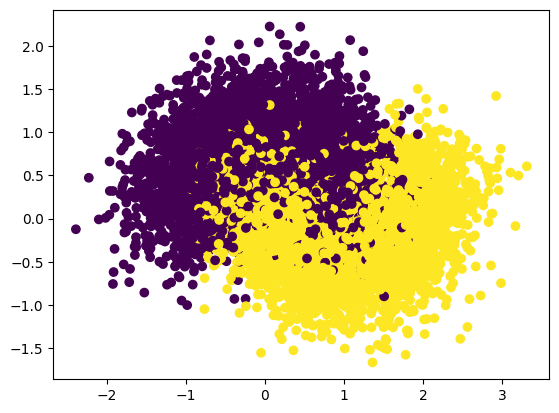

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

c. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [ ]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [ ]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [ ]:
y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## 8.

_Exercise: Grow a forest._

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [ ]:
n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [ ]:
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)

    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.805471

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [ ]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [ ]:
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [ ]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

# Decision trees на іншому наборі даних

## Loading

In [ ]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/MIS'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


In [ ]:
loan_df = pd.read_csv(data_dir + '/loan_prediction_train.csv')

In [ ]:
loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Preparing

In [ ]:
loan_df['Credit_History'] = loan_df['Credit_History'].astype('O')

In [ ]:
loan_df.drop('Loan_ID', axis=1, inplace=True)

In [ ]:
loan_df.dropna(inplace=True)

In [ ]:
loan_df.describe(include='O')

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
count,480,480,480,480,480,480.0,480,480
unique,2,2,4,2,2,2.0,3,2
top,Male,Yes,0,Graduate,No,1.0,Semiurban,Y
freq,394,311,274,383,414,410.0,191,332


In [ ]:
loan_labels = loan_df["Loan_Status"]
loan_attrib = loan_df.drop('Loan_Status', axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

one_hot_attribs = ["Gender", "Married", "Education", "Self_Employed", "Credit_History", "Property_Area"]
ord_attribs = ["Dependents"]

full_pipeline = ColumnTransformer([
        ("one_hot", OneHotEncoder(sparse_output=False), one_hot_attribs),
        ("ord", OrdinalEncoder(), ord_attribs)
    ], remainder='passthrough')

X = full_pipeline.fit_transform(loan_attrib)
le = LabelEncoder()
y = le.fit_transform(loan_labels)

In [ ]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4583.0,1508.0,128.0,360.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3000.0,0.0,66.0,360.0
2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2583.0,2358.0,120.0,360.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6000.0,0.0,141.0,360.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,5417.0,4196.0,267.0,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2900.0,0.0,71.0,360.0
476,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,4106.0,0.0,40.0,180.0
477,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,8072.0,240.0,253.0,360.0
478,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,7583.0,0.0,187.0,360.0


In [ ]:
pd.DataFrame(y)

,0
0,0
1,1
2,1
3,1
4,1
...,...
475,1
476,1
477,1
478,1


## Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training and evaluating decision tree

In [ ]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, scoring = 'accuracy', verbose=1, cv=10)

grid_search_cv.fit(X_train, y_train)

Fitting 10 folds for each of 297 candidates, totalling 2970 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy', verbose=1)

In [ ]:
cvres = grid_search_cv.cv_results_
for score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(score, params)

0.8047908232118758 {'max_leaf_nodes': 2, 'min_samples_split': 2}
0.8047908232118758 {'max_leaf_nodes': 2, 'min_samples_split': 3}
0.8047908232118758 {'max_leaf_nodes': 2, 'min_samples_split': 4}
0.7863697705802969 {'max_leaf_nodes': 3, 'min_samples_split': 2}
0.7863697705802969 {'max_leaf_nodes': 3, 'min_samples_split': 3}
0.7863697705802969 {'max_leaf_nodes': 3, 'min_samples_split': 4}
0.7784750337381916 {'max_leaf_nodes': 4, 'min_samples_split': 2}
0.7784750337381916 {'max_leaf_nodes': 4, 'min_samples_split': 3}
0.7784750337381916 {'max_leaf_nodes': 4, 'min_samples_split': 4}
0.7758434547908232 {'max_leaf_nodes': 5, 'min_samples_split': 2}
0.7758434547908232 {'max_leaf_nodes': 5, 'min_samples_split': 3}
0.7758434547908232 {'max_leaf_nodes': 5, 'min_samples_split': 4}
0.7811066126855601 {'max_leaf_nodes': 6, 'min_samples_split': 2}
0.7811066126855601 {'max_leaf_nodes': 6, 'min_samples_split': 3}
0.7811066126855601 {'max_leaf_nodes': 6, 'min_samples_split': 4}
0.7865047233468285 {'max_

In [ ]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=2, random_state=42)

In [ ]:
grid_search_cv.best_estimator_.tree_.node_count

3

9 - split on education

In [ ]:
grid_search_cv.best_estimator_.tree_.feature

array([ 9, -2, -2], dtype=int64)

In [ ]:
grid_search_cv.best_estimator_.tree_.threshold

array([ 0.5, -2. , -2. ])

In [ ]:
y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8229166666666666

## Training and evaluating random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'n_estimators': [20, 50, 100, 200, 1000], 'max_features': [2, 4, 8, None], 'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128, None]},
  ]

grid_search_cv_forest = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs = -1)
grid_search_cv_forest.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 8, None],
                          'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128, None],
                          'n_estimators': [20, 50, 100, 200, 1000]}],
             scoring='accuracy', verbose=1)

In [ ]:
grid_search_cv_forest.best_estimator_

RandomForestClassifier(max_features=2, max_leaf_nodes=64, n_estimators=50,
                       random_state=42)

In [ ]:
grid_search_cv_forest.best_score_

0.8100478468899521

In [ ]:
y_pred = grid_search_cv_forest.predict(X_test)
accuracy_score(y_test, y_pred)

0.8333333333333334